## Imports and Loading

In [1]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE

from load_data_fn import load_data,load_data_no_filter

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib


In [2]:
import AE_Stats
importlib.reload(AE_Stats)


<module 'AE_Stats' from '/uscms_data/d3/nswood/Notebooks/ECON_AE_Development/AE_Stats.py'>

In [2]:
dt,dt_loc = load_data(1)

## Loss Functions

In [5]:
def AE_MSE(data,pred):
    return torch.mean(torch.sum((data-pred)**2,dim=1))

def AE_MAE(data,pred):
    return torch.mean(torch.sum(torch.abs(data-pred),dim=1))

def weighted_AE_MSE(data, pred):
    return torch.mean(torch.sum((data[:,0:48])**2,dim=1)*torch.sum((data-pred)**2,dim=1))

def dif_weighted_AE_MSE(data, pred,alpha = 1):
    return torch.mean(((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))

def log_dif_weighted_AE_MSE(data, pred,alpha = 1):
    return torch.mean(torch.log((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))

# Data Loading

In [18]:
size_train =50000
size_test = 50000
train_loc = dt_loc[0:size_train]
test_loc = dt_loc[-size_test:]
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_dl_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=100,
    shuffle=False
)

test_loc_dl_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=100,
    shuffle=False
)

train = dt[0:size_train]
test = dt[-size_test:]
# train = torch.vstack([train,largest[0:1000]] )
train=train[torch.randperm(train.size()[0])]
test=test[torch.randperm(test.size()[0])]
train_dl_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=100,
    shuffle=False
)

test_dl_flat = DataLoader(
    TensorDataset(torch.Tensor(test)),
    batch_size=100,
    shuffle=False
)

# Models and Trainings
Settings for all models below:

In [39]:
num_epochs = 100
lr = 0.00025
loss = dif_weighted_AE_MSE

MSE 9.513029098510742
Median 0.9991147518157959
Standard Devitaion 67.99283599853516
Average % Error 174.3890838623047


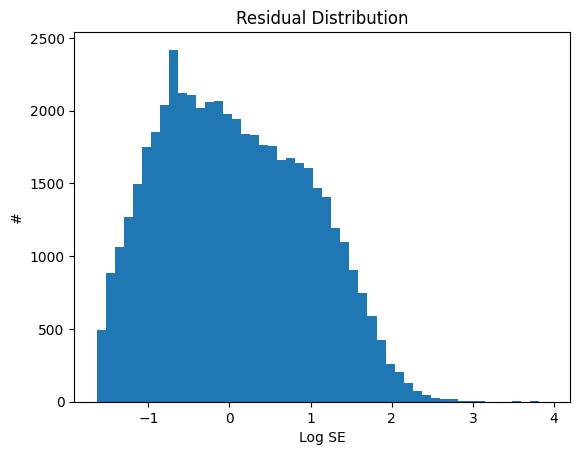

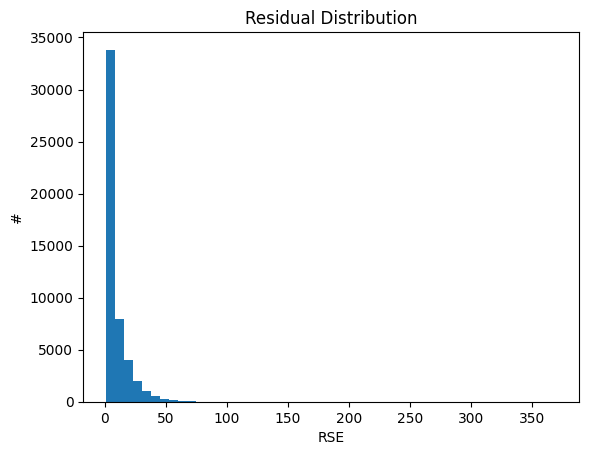

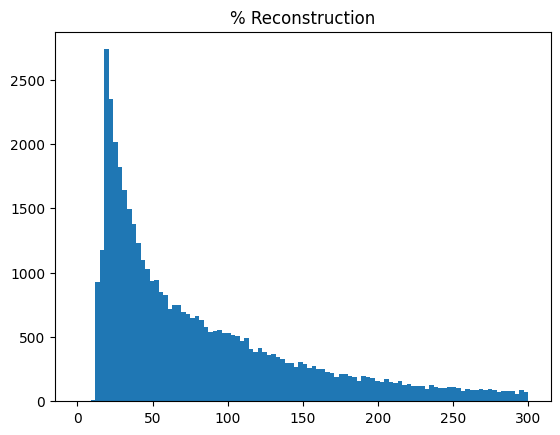

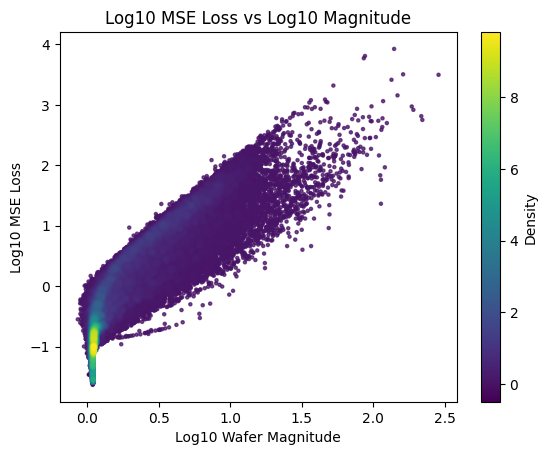

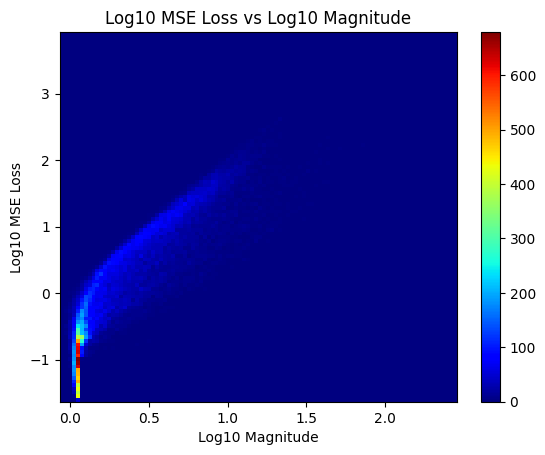

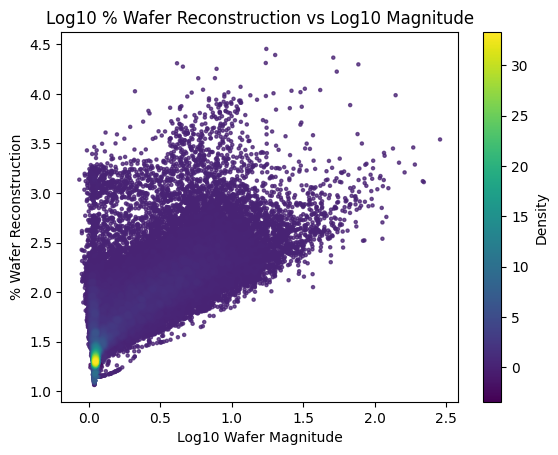

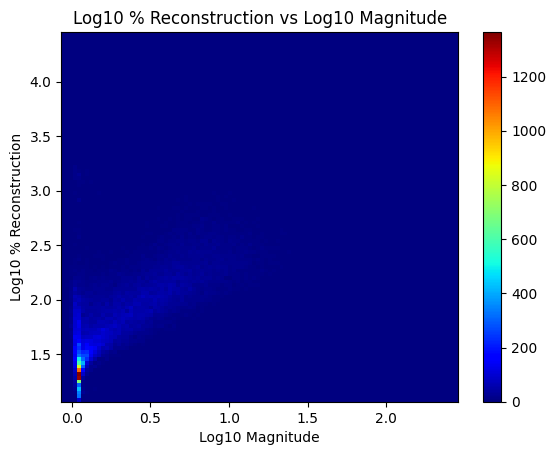

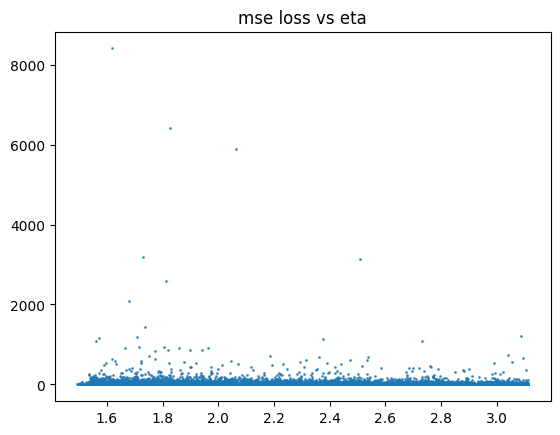

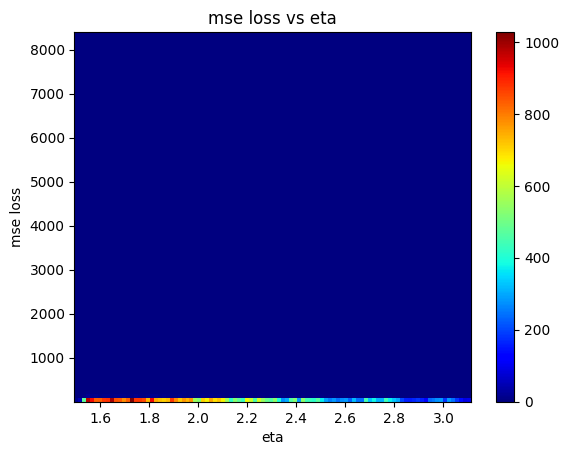

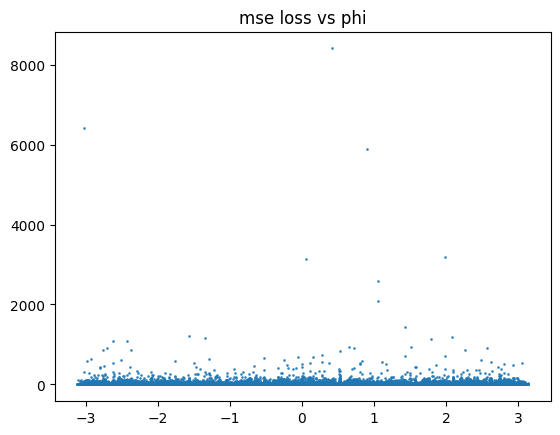

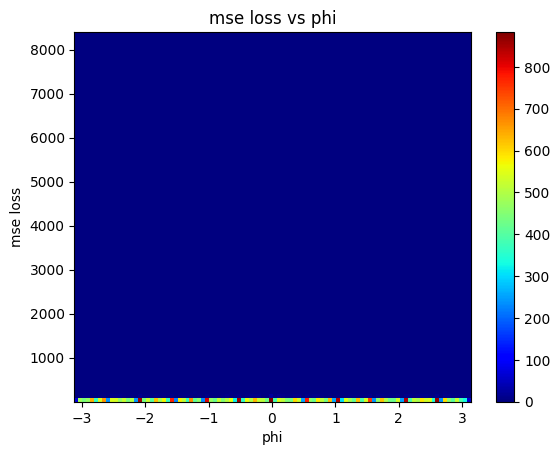

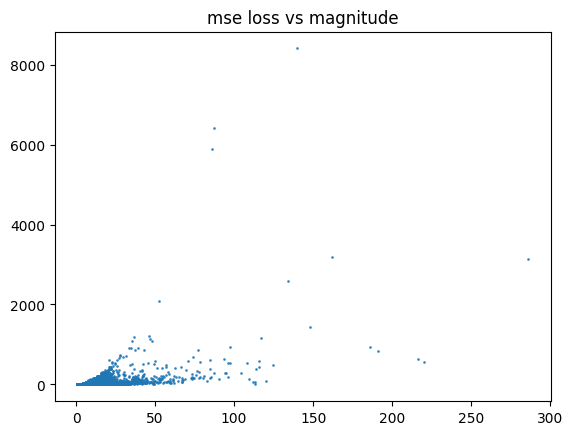

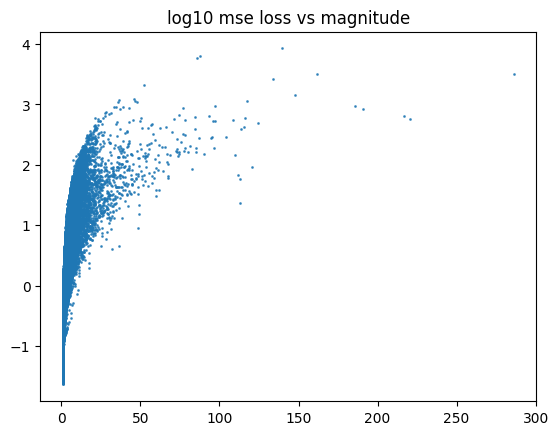

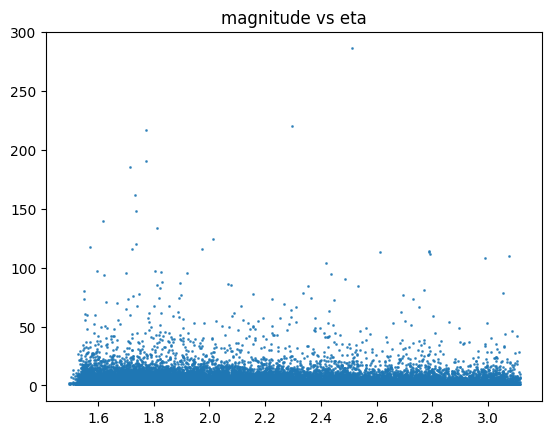

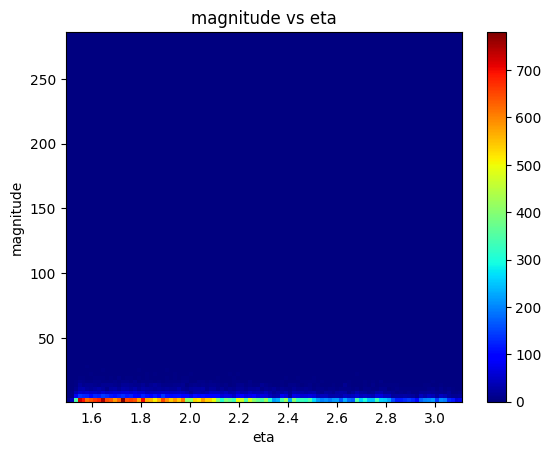

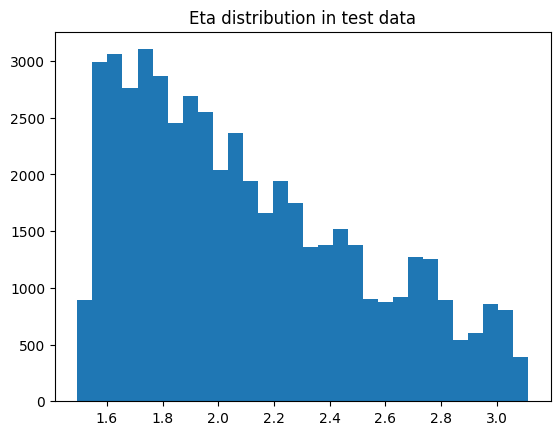

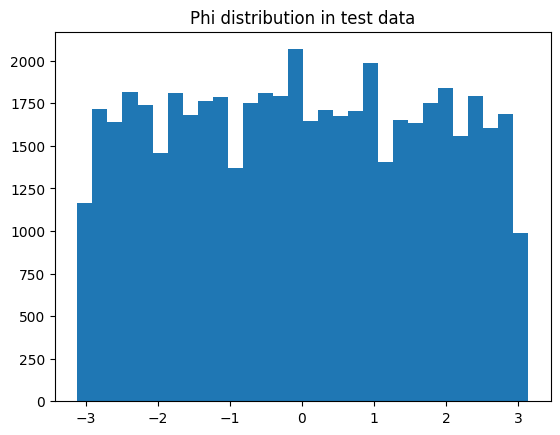

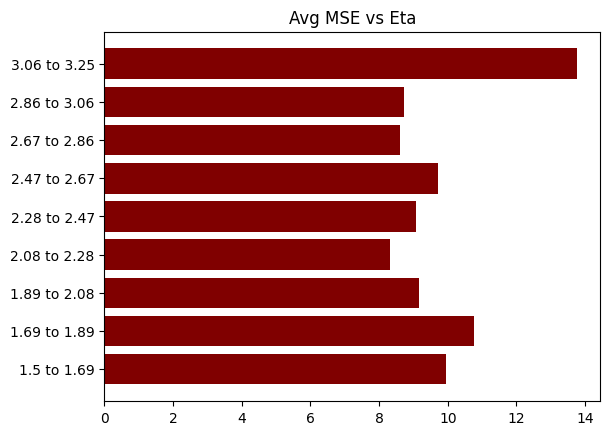

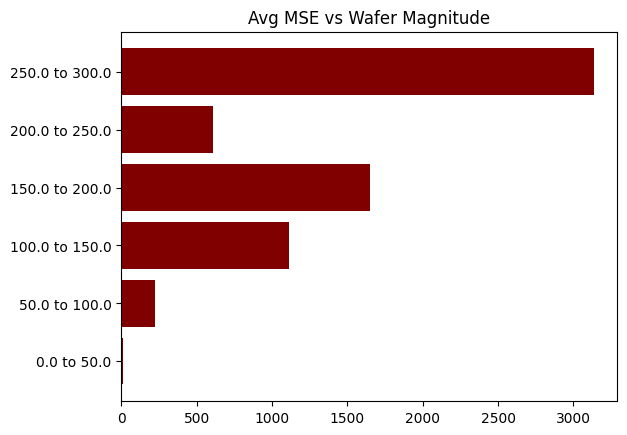

tensor([[ 2.7934, -0.3303,  1.2164,  0.9382,  3.5006],
        [ 1.8060,  2.0979,  4.7119, 18.5687, 18.5656],
        [ 1.5569,  1.7968,  1.1297,  0.5260,  3.0011],
        ...,
        [ 2.0485, -2.9879,  1.8024,  1.0929,  3.7699],
        [ 2.9795, -0.1205,  4.6748,  4.9193, 12.2857],
        [ 2.7891, -1.7612,  7.4439,  2.7413,  8.2706]], grad_fn=<CatBackward0>)

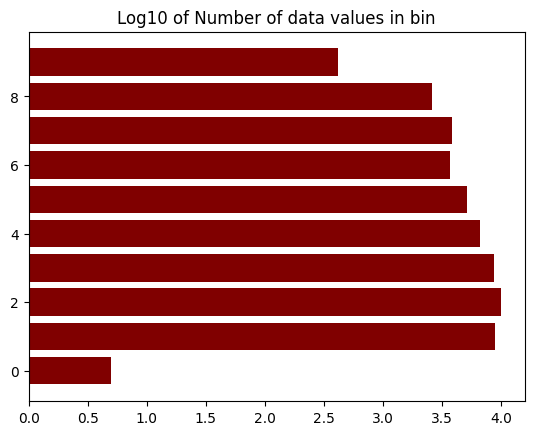

In [53]:
# fine-tune autoencoder
#batch 500


# model_5 = Naive_DAE([48,400,100,16,16])

optimizer = optim.Adam(model_5.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    break
    losses = []
    
    for i, data_list in enumerate(train_dl_flat):
        model_5.train()
        data = data_list[0]
        v_pred = model_5(data)
        
        batch_loss = loss(data, v_pred,alpha = 0.25) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_test = test
    model_5.eval()
    test_pred = model_5(data_test)
    batch_test = loss(data_test, test_pred)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
model_5.eval()
AE_Stats.gen_all_stats(model_5(test),test,test_loc)


Model Description: Trying going much bigger

torch.load('model_48_250_100_16') and reducing alpha to 0.01

In [54]:
# fine-tune autoencoder
#batch 500

# model_loc = Naive_DAE([50,250,100,50,25,16],with_loc = True)

optimizer = optim.Adam(model_loc.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

all_test_losses = []
all_train_losses = []

# train
running_loss = float("inf")
for epoch in range(num_epochs):
    break
    losses = []
    
    for i, data_list in enumerate(train_loc_dl_flat):
        data = data_list[0]
        v_pred = model_loc(data)
        
        batch_loss = loss(data[:,0:48], v_pred, alpha = 0.1) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_test = test_loc
    test_pred = model_loc(data_test)
    batch_test = loss(data_test[:,0:48], test_pred)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
AE_Stats.generate_stats(model_loc(test_loc),test,test_loc)


NameError: name 'model_loc' is not defined

MSE 1.9457690715789795
Median 0.08047907799482346
Standard Devitaion 12.062112808227539
Average % Error 93.87908172607422


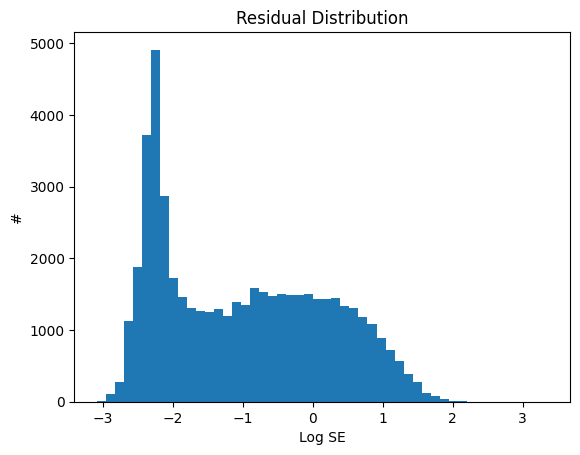

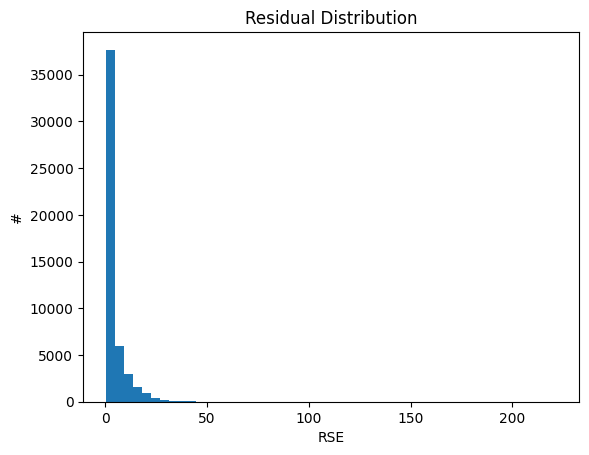

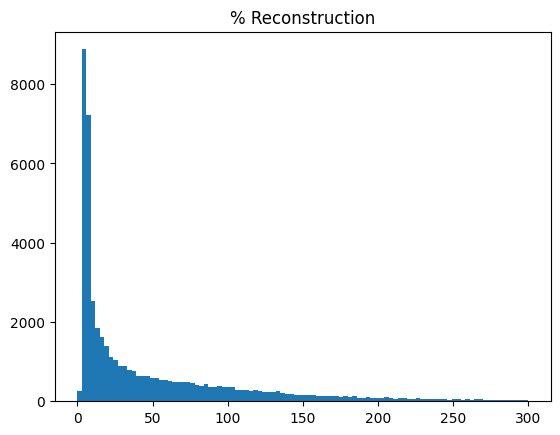

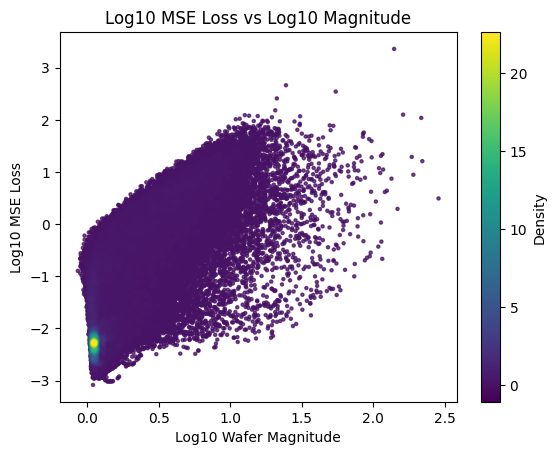

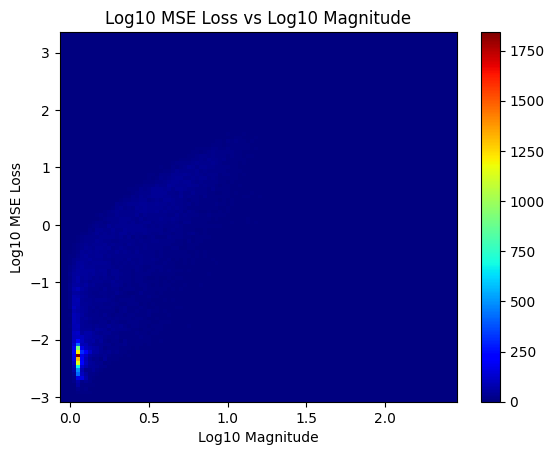

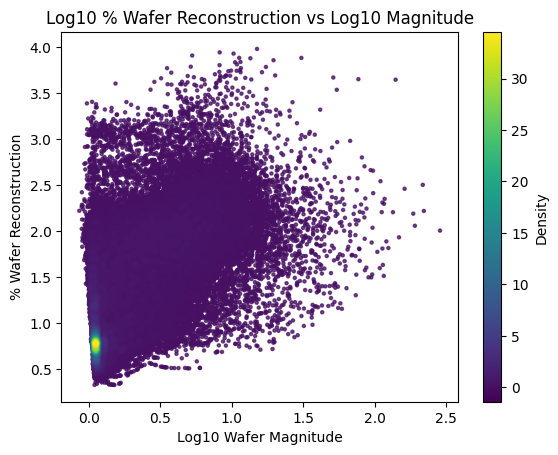

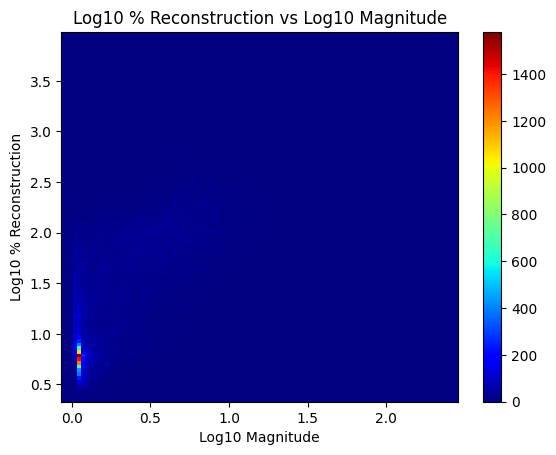

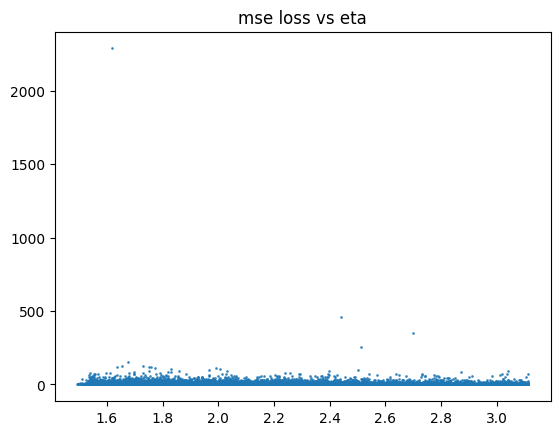

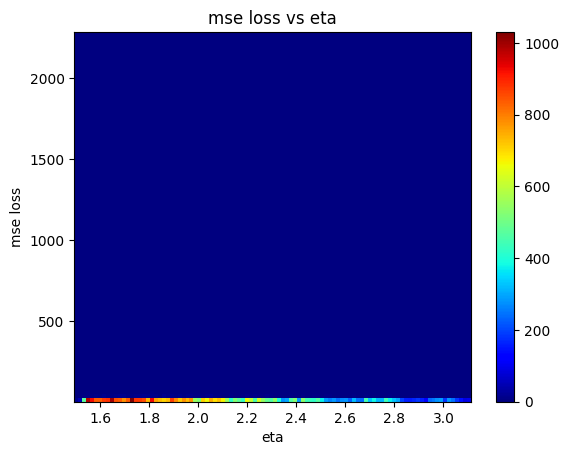

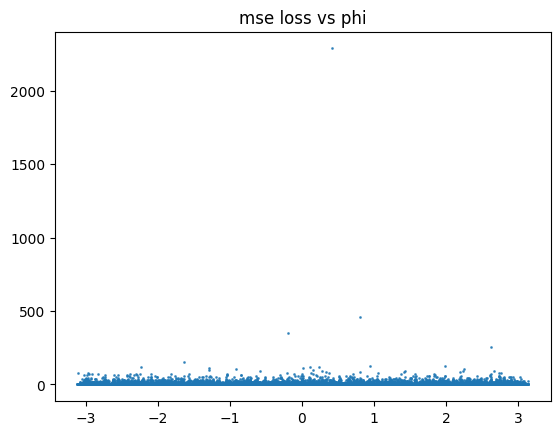

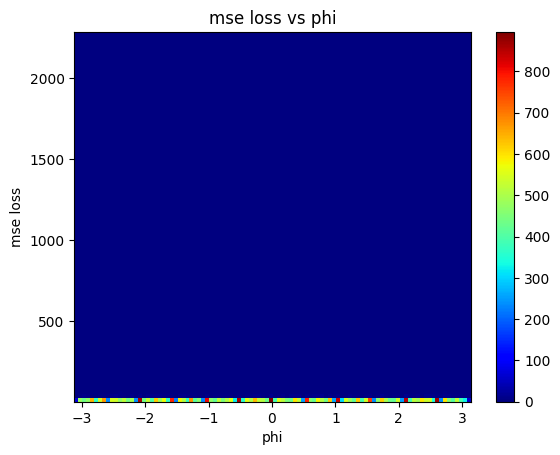

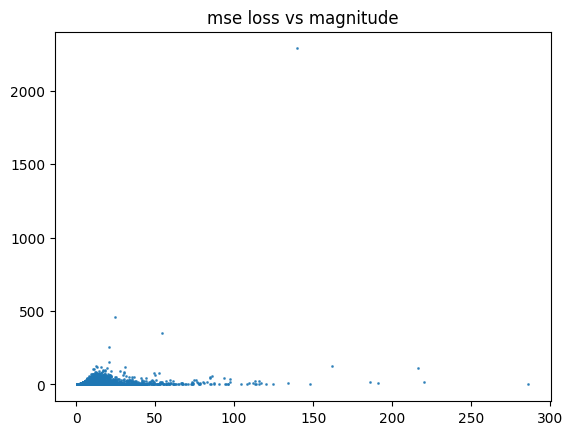

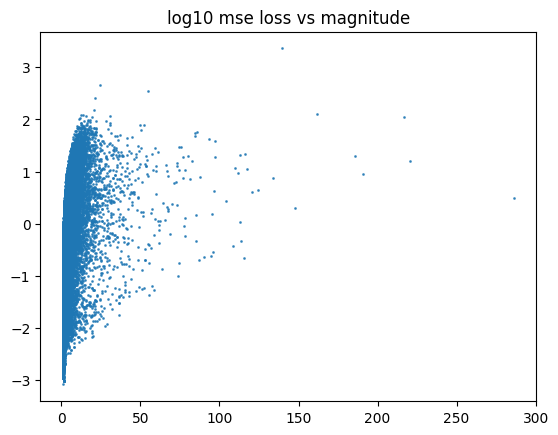

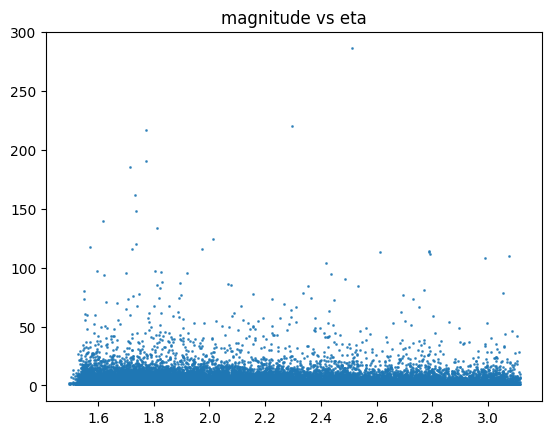

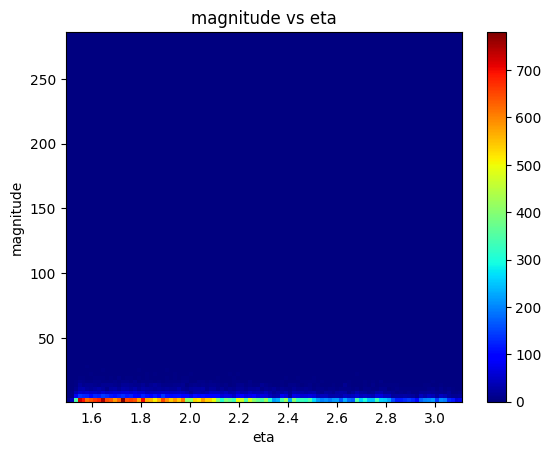

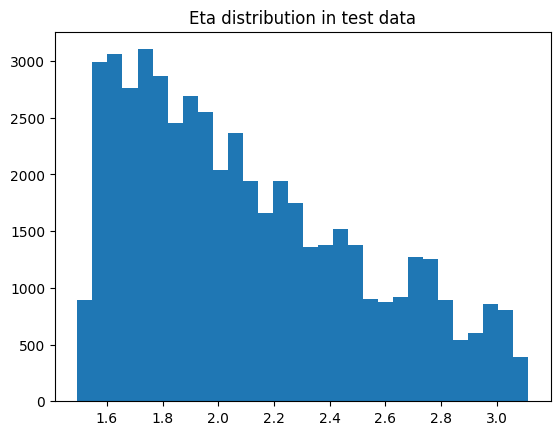

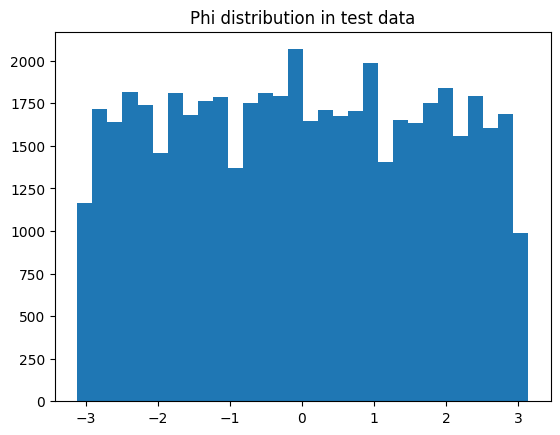

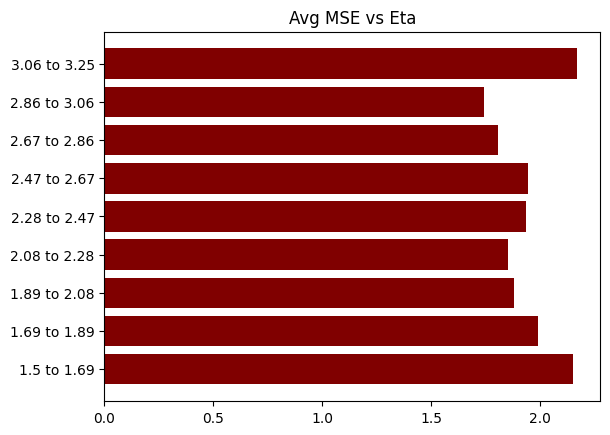

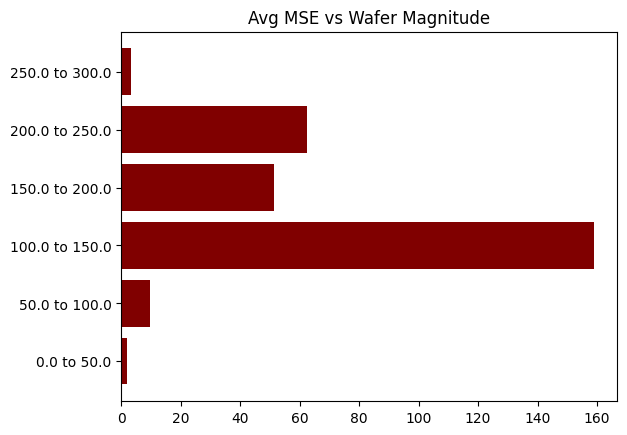

tensor([[ 2.7934, -0.3303,  1.2164,  0.1070,  1.2942],
        [ 1.8060,  2.0979,  4.7119,  2.4162,  8.1172],
        [ 1.5569,  1.7968,  1.1297,  0.2175,  1.7905],
        ...,
        [ 2.0485, -2.9879,  1.8024,  0.1432,  1.8987],
        [ 2.9795, -0.1205,  4.6748,  0.9561,  3.4784],
        [ 2.7891, -1.7612,  7.4439,  0.2440,  1.6526]], grad_fn=<CatBackward0>)

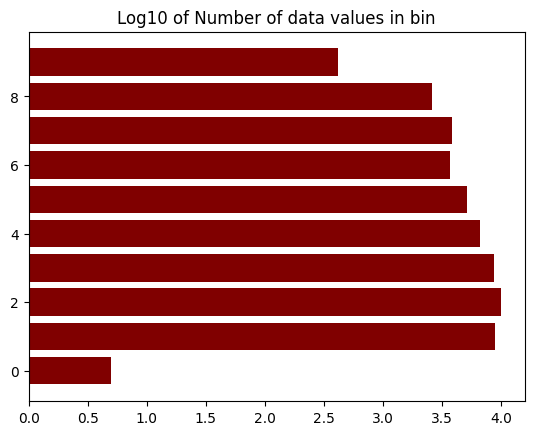

In [55]:
# fine-tune autoencoder
#batch 500

model_4 = torch.load('model_48_250_100_16')

optimizer = optim.Adam(model_4.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.75)

all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    break
    losses = []
    
    for i, data_list in enumerate(train_dl_flat):
        data = data_list[0]
        v_pred = model_4(data)
        
        batch_loss = loss(data, v_pred, alpha = 0.15) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_test = test
    test_pred = model_4(data_test)
    batch_test = loss(data_test, test_pred)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
AE_Stats.gen_all_stats(model_4(test),test,test_loc)


In [21]:
model_loc(test_loc)[0]

tensor([-0.0415, -0.0326,  0.0272,  0.0148,  0.0273,  0.1559, -0.0080,  0.0215,
         0.0252,  0.0820,  0.0760,  0.0498, -0.0292,  0.0209, -0.0514,  0.0252,
        -0.0155, -0.0117,  0.0565, -0.0368, -0.0045,  0.0682,  0.0037, -0.0381,
         0.0173,  0.0585, -0.0553, -0.0271,  0.0932, -0.0145, -0.0495,  0.0184,
        -0.0366, -0.0217,  0.0495, -0.0491, -0.0434, -0.0542,  0.0439,  0.0747,
        -0.0306,  0.0240,  0.0191,  0.0581, -0.0658,  0.0077,  0.0952, -0.0132,
         0.0128, -0.0662], grad_fn=<SelectBackward0>)

In [27]:
model_loc.parameters

<bound method Module.parameters of Naive_DAE(
  (encoders): ModuleList(
    (0): Linear(in_features=50, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=16, bias=True)
    (5): ReLU()
  )
  (decoders): ModuleList(
    (0): ReLU()
    (1): Linear(in_features=16, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=250, bias=True)
    (4): ReLU()
    (5): Linear(in_features=250, out_features=48, bias=True)
  )
)>

In [48]:
# fine-tune autoencoder
#batch 500

# model_3 = Naive_DAE([48,250,100,20])


# now trying to slightly weigh for lower weight wafers

optimizer = optim.Adam(model_3.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    break
    losses = []
    
    for i, data_list in enumerate(train_dl_flat):
        data = data_list[0]
        v_pred = model_3(data)
        
        batch_loss = loss(data, v_pred, alpha = 0.25) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_test = test
    test_pred = model_3(data_test)
    batch_test = loss(data_test, test_pred)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
generate_stats(model_3(test),test,test_loc)


NameError: name 'model_3' is not defined

Model Description: Deeper model with only layers less than 48

[48,200,100,16]


Epoch 0, lr 1e-05
Epoch 0: Train 5.176346624070406, Test 46.1484489440918
Epoch 1, lr 1e-05
Epoch 1: Train 5.1561460083782675, Test 45.984981536865234
Epoch 2, lr 1e-05
Epoch 2: Train 5.146239060074091, Test 45.87655258178711
Epoch 3, lr 1e-05
Epoch 3: Train 5.137911337256432, Test 45.76833724975586
Epoch 4, lr 1e-05
Epoch 4: Train 5.130405730456114, Test 45.67863464355469
Epoch 5, lr 1e-05
Epoch 5: Train 5.123146775263548, Test 45.591312408447266
Epoch 6, lr 1e-05
Epoch 6: Train 5.11611200773716, Test 45.51433563232422
Epoch 7, lr 1e-05
Epoch 7: Train 5.109579728150368, Test 45.42500305175781
Epoch 8, lr 1e-05
Epoch 8: Train 5.103031223803758, Test 45.36455535888672
Epoch 9, lr 1e-05
Epoch 9: Train 5.09687125774622, Test 45.2811279296875
Epoch 10, lr 1e-05
Epoch 10: Train 5.090585156971216, Test 45.21151351928711
Epoch 11, lr 1e-05
Epoch 11: Train 5.084345947933197, Test 45.1346549987793
Epoch 12, lr 1e-05
Epoch 12: Train 5.078366068446636, Test 45.05958557128906
Epoch 13, lr 1e-05
Ep

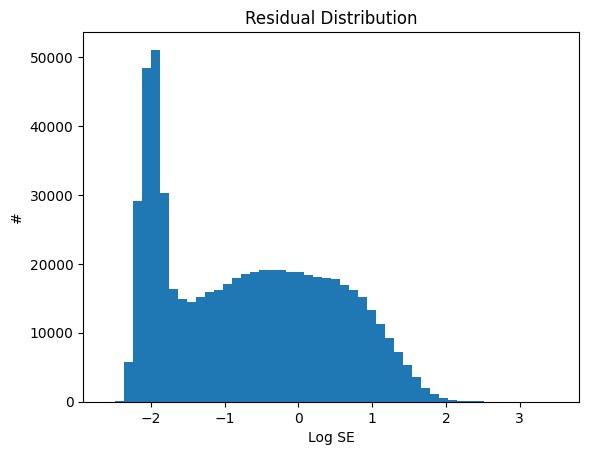

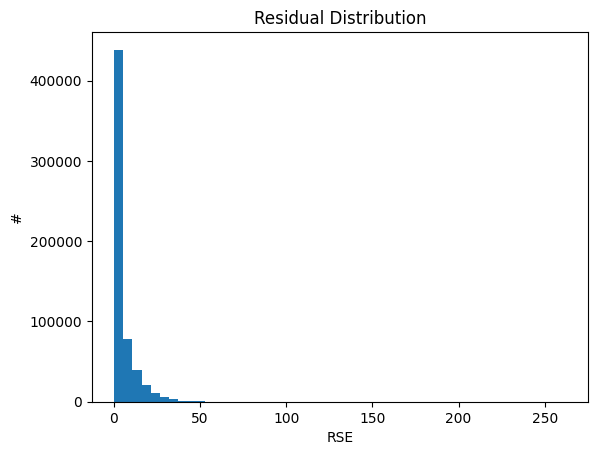

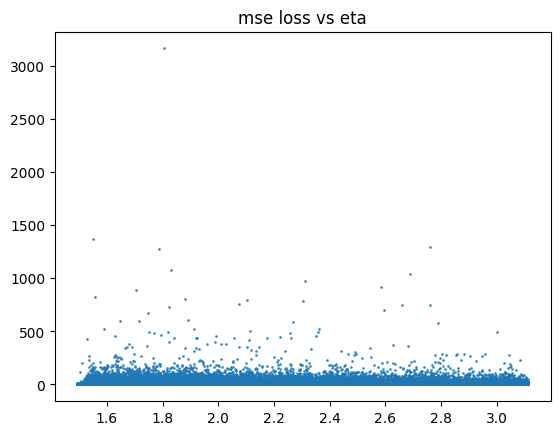

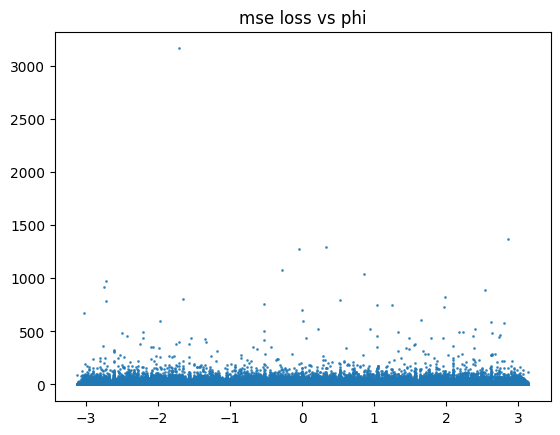

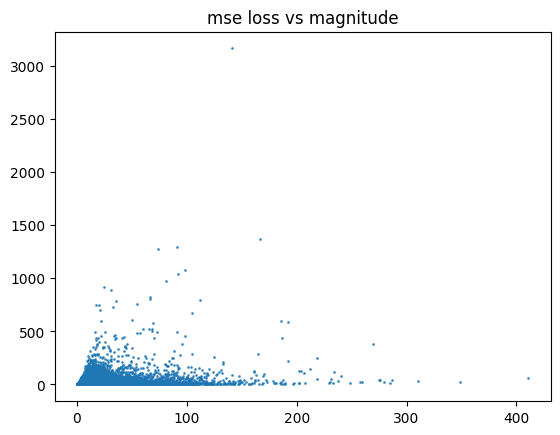

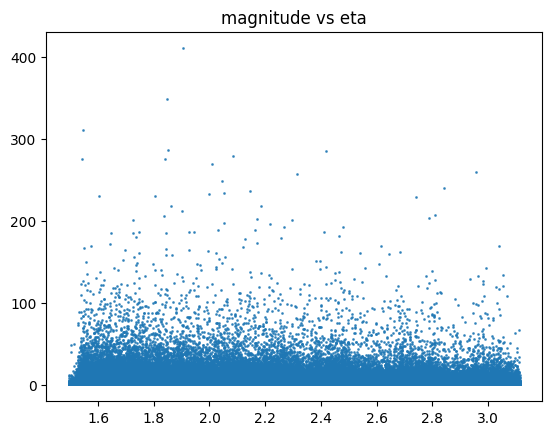

In [62]:
###### fine-tune autoencoder
#batch 500

# model_7 = Naive_DAE([48,250,100,16])

optimizer = optim.Adam(model_7.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    losses = []
    
    for i, data_list in enumerate(train_dl_flat):
        data = data_list[0]
        v_pred = model_7(data)
        
        batch_loss = loss(data, v_pred,alpha = 0.05) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_test = test
    test_pred = model_7(data_test)
    batch_test = loss(data_test, test_pred)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
generate_stats(model_7(test),test,test_loc)


Epoch 0, lr 1e-05
Epoch 0: Train 1238.2251432731628, Test 1060.4503173828125
Epoch 1, lr 1e-05
Epoch 1: Train 919.5087950994491, Test 1060.4503173828125
Epoch 2, lr 1e-05
Epoch 2: Train 709.3396523180961, Test 1060.4503173828125
Epoch 3, lr 1e-05
Epoch 3: Train 653.3616690236569, Test 1060.4503173828125
Epoch 4, lr 1e-05
Epoch 4: Train 705.6387482100487, Test 1060.4503173828125
Epoch 5, lr 1e-05
Epoch 5: Train 790.4312985127449, Test 1060.4503173828125
Epoch 6, lr 1e-05
Epoch 6: Train 834.4099276608467, Test 1060.4503173828125
Epoch 7, lr 1e-05
Epoch 7: Train 795.5130064637184, Test 1060.4503173828125
Epoch 8, lr 1e-05
Epoch 8: Train 677.2296826591491, Test 1060.4503173828125
Epoch 9, lr 1e-05
Epoch 9: Train 517.5008080174446, Test 1060.4503173828125
Epoch 10, lr 1e-05
Epoch 10: Train 361.4523952543259, Test 1060.4503173828125
Epoch 11, lr 1e-05
Epoch 11: Train 241.82866595144273, Test 1060.4503173828125
Epoch 12, lr 1e-05
Epoch 12: Train 169.68088592171668, Test 1060.4503173828125
Epo

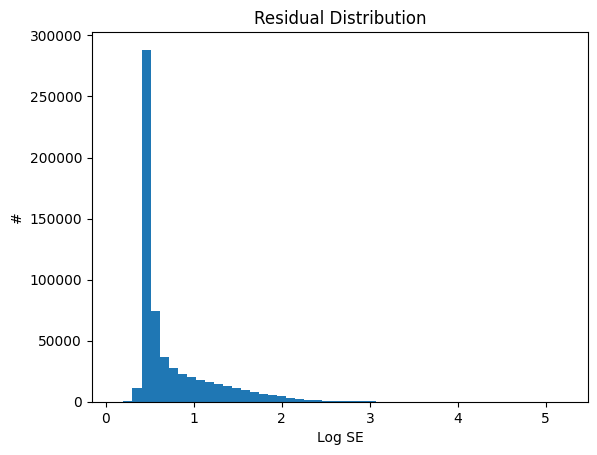

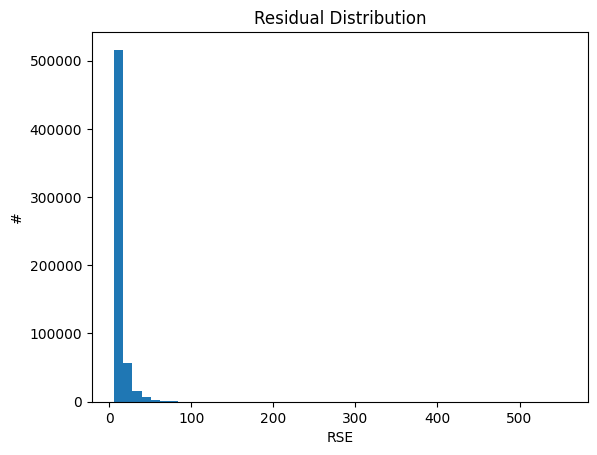

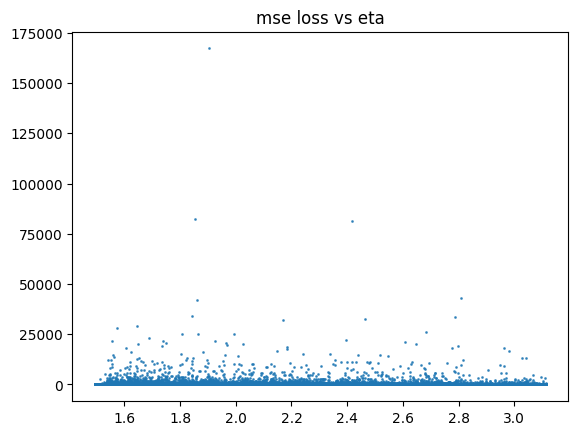

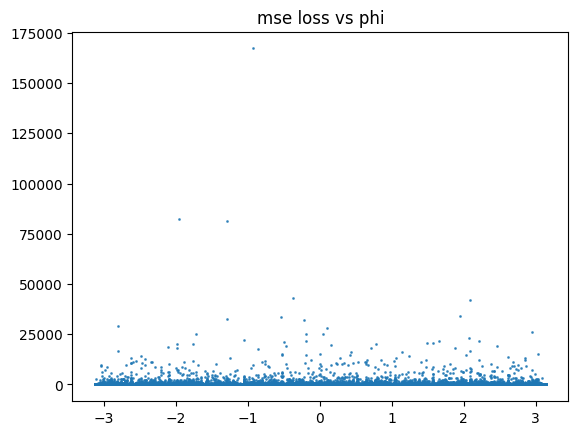

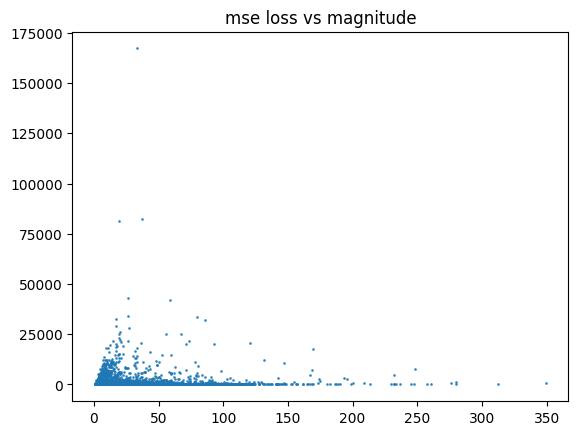

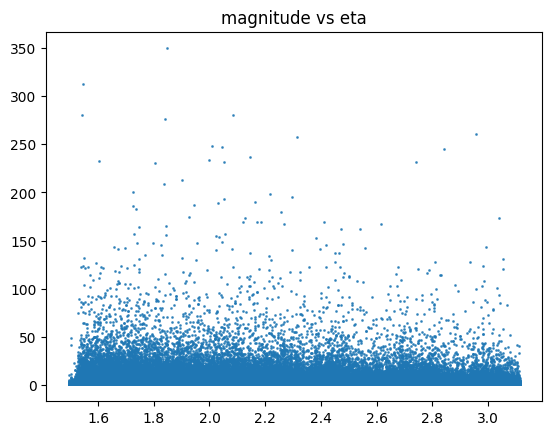

In [65]:
# fine-tune autoencoder
#batch 500
model_6 = Naive_DAE([48,250,100,16])

optimizer = optim.Adam(model_6.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)


all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_dl_flat):
        alpha_calc = 0.375 - 0.125*np.sin(epoch*2*np.pi/10)
        data = data_list[0]
        v_pred = model_6(data)
        
        batch_loss = loss(data, v_pred, alpha = alpha_calc) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_test = test
    test_pred = model_1(data_test)
    batch_test = loss(data_test, test_pred)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
generate_stats(model_1(test),test,test_loc)


Epoch 0, lr 1e-05
Epoch 0: Train 837.2754856764793, Test 1060.4503173828125
Epoch 1, lr 1e-05
Epoch 1: Train 758.5884355318069, Test 1060.4503173828125
Epoch 2, lr 1e-05
Epoch 2: Train 683.8766554769993, Test 1060.4503173828125
Epoch 3, lr 1e-05
Epoch 3: Train 630.0767778263569, Test 1060.4503173828125
Epoch 4, lr 1e-05
Epoch 4: Train 581.2724945466995, Test 1060.4503173828125
Epoch 5, lr 1e-05
Epoch 5: Train 536.4424291006565, Test 1060.4503173828125
Epoch 6, lr 1e-05
Epoch 6: Train 489.7478962349892, Test 1060.4503173828125
Epoch 7, lr 1e-05
Epoch 7: Train 438.10391340179444, Test 1060.4503173828125
Epoch 8, lr 1e-05
Epoch 8: Train 382.7103479854584, Test 1060.4503173828125
Epoch 9, lr 1e-05
Epoch 9: Train 326.77295613179206, Test 1060.4503173828125
Epoch 10, lr 1e-05
Epoch 10: Train 274.77777350707055, Test 1060.4503173828125
Epoch 11, lr 1e-05
Epoch 11: Train 228.80962767882346, Test 1060.4503173828125
Epoch 12, lr 1e-05
Epoch 12: Train 188.49618466029168, Test 1060.4503173828125
E

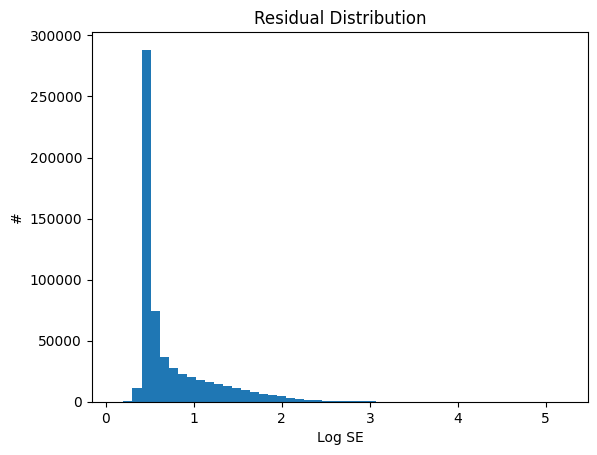

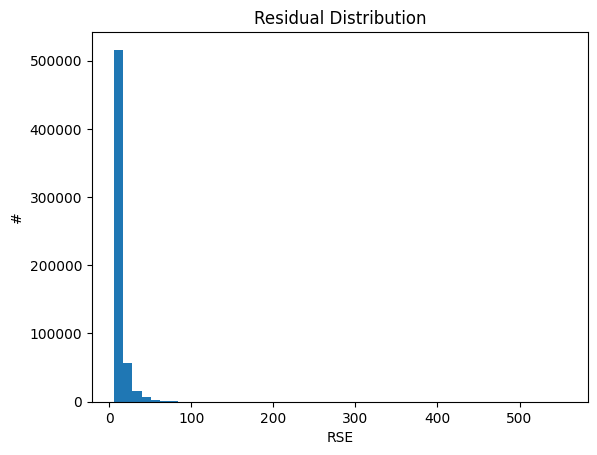

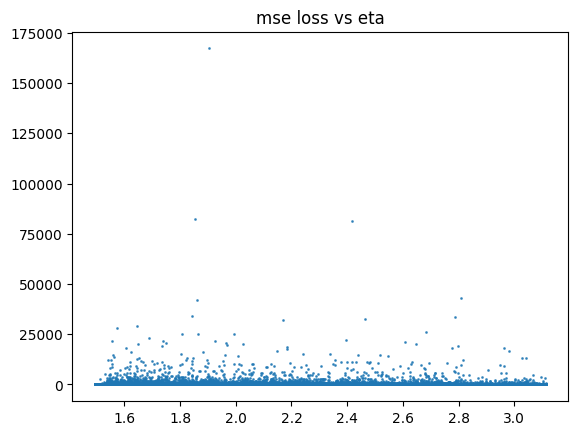

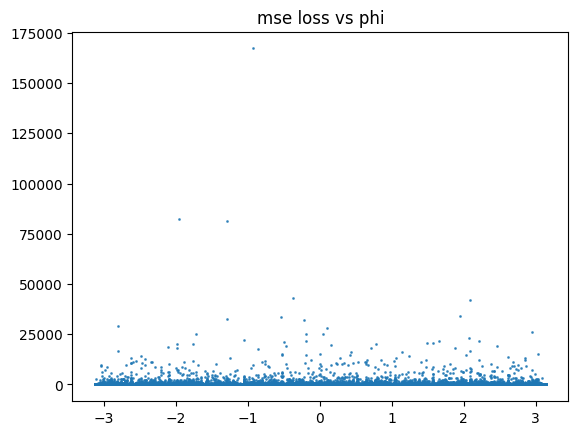

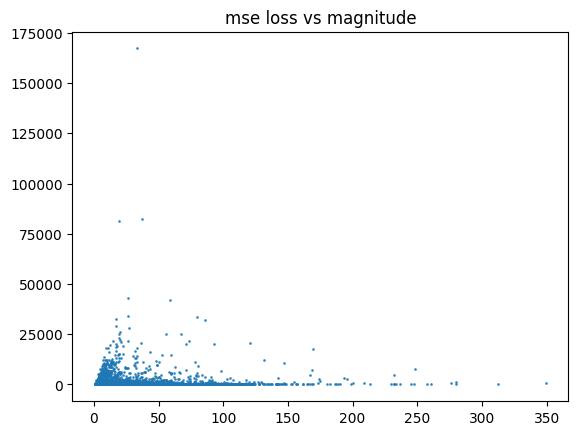

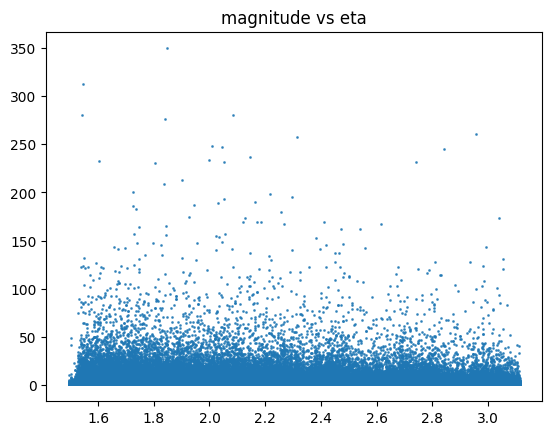

In [66]:
# fine-tune autoencoder
#batch 500
model_8 = Naive_DAE([48,250,100,16])

optimizer = optim.Adam(model_8.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)


all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_dl_flat):
        alpha_calc = 0.25 - 0.2*epoch/num_epochs
        data = data_list[0]
        v_pred = model_8(data)
        
        batch_loss = loss(data, v_pred, alpha = alpha_calc) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_test = test
    test_pred = model_1(data_test)
    batch_test = loss(data_test, test_pred)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
generate_stats(model_1(test),test,test_loc)


In [ ]:
# Going to make method to plot reconstruction loss vs eta, phi, magnitude of wafer
#eta | phi | magnitude | reconstruction loss

In [56]:
# torch.save(model_3,'model_48_250_100_20')

In [75]:
torch.save(model_5,'model_48_250_100_16_valentines')

In [37]:
!ls

AE_Data			  ECON_AE_Development  VAE.ipynb
AE for Application.ipynb  model_48_250_16      weighted_dae
DAE.ipynb		  RBM_AE.ipynb
data			  uproot_loader.ipynb


# RBM Section


I think RBM may be not functioning well because it is not normalized. Will try with normalized data

In [59]:
maxes = torch.max(dt, dim = 0)
maxes = maxes[0]
maxes = maxes.to(device='cuda')

# dt_norm = (dt / dt.max(0, keepdim=True)[0])[:,0:48]

In [96]:
hidden_dimensions = [
    {
        "hidden_dim": 48, 
        "num_epochs": 5, 
        "learning_rate": 0.001, 
        "display_dim1": 48, 
        "use_gaussian": False
    }, 
    {
        "hidden_dim": 48, 
        "num_epochs": 5, 
        "learning_rate": 0.001, 
        "display_dim1": 32, 
        "use_gaussian": False
    },
    {
        "hidden_dim": 32, 
        "num_epochs": 5, 
        "learning_rate": 0.001, 
        "display_dim1": 24, 
        "use_gaussian": False
    },
    {
        "hidden_dim": 24, 
        "num_epochs": 5, 
        "learning_rate": 0.001, 
        "display_dim1": 16,  
        "use_gaussian": False
    },
    {
        "hidden_dim": 16, 
        "num_epochs": 10, 
        "learning_rate": 0.0001, # use much lower LR for gaussian to avoid exploding gradient
        "display_dim1": 16, 
        "use_gaussian": True # use a Gaussian distribution for the last hidden layer to let it take advantage of continuous values
    }
]


In [97]:
train_norm = torch.tensor(dt[0:50000]).cuda()
test_norm = torch.tensor(dt).cuda()
train_dl_RBM = DataLoader(
    TensorDataset(torch.Tensor(train_norm).to(DEVICE)),
    batch_size=500,
    shuffle=False
)
test_dl_RBM = DataLoader(
    TensorDataset(torch.Tensor(test_norm).to(DEVICE)),
    batch_size=500,
    shuffle=False
)



/tmp/ipykernel_214478/2632008623.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_norm = torch.tensor(dt[0:50000]).cuda()
/tmp/ipykernel_214478/2632008623.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_norm = torch.tensor(dt).cuda()


In [101]:
# get initial iteration of new training dl
new_train_dl = train_dl_flat

visible_dim = 48
hidden_dim = None
models = [] # trained RBM models
for configs in hidden_dimensions:
    
    # parse configs
    hidden_dim = configs["hidden_dim"]
    num_epochs = configs["num_epochs"]
    lr = configs["learning_rate"]
    
    use_gaussian = configs["use_gaussian"]
    
    # train RBM
    print(f"{visible_dim} to {hidden_dim}")
    model, v, v_pred = train_rbm(new_train_dl, visible_dim, hidden_dim, k=1, num_epochs=num_epochs, lr=lr, use_gaussian=use_gaussian)
    models.append(model)
    

    # rederive new data loader based on hidden activations of trained model
    new_data = []
    for data_list in new_train_dl:
        p = model.sample_h(data_list[0])[0]
        new_data.append(p.detach().cpu().numpy())
    new_input = np.concatenate(new_data)
    new_train_dl = DataLoader(
        TensorDataset(torch.Tensor(new_input).to(DEVICE)), 
        batch_size=1000, 
        shuffle=False
    )
    
    # update new visible_dim for next RBM
    visible_dim = hidden_dim

48 to 48
epoch 0: 1306.54345703125
epoch 1: 1306.5430908203125
epoch 2: 1306.5430908203125
epoch 3: 1306.5430908203125
epoch 4: 1306.5430908203125
48 to 48
epoch 0: 0.006577463820576668
epoch 1: 0.000183112031663768
epoch 2: 0.00017260578169953078
epoch 3: 0.00017022137762978673
epoch 4: 0.00016906471864786
48 to 32
epoch 0: 0.008263275027275085
epoch 1: 0.00013279863924253732
epoch 2: 0.00012387195602059364
epoch 3: 0.00012023885210510343
epoch 4: 0.00011479225941002369
32 to 24
epoch 0: 0.010082107968628407
epoch 1: 0.00022981641814112663
epoch 2: 0.00020206304907333106
epoch 3: 0.00019533687736839056
epoch 4: 0.00019015988800674677
24 to 16
epoch 0: 0.03351658210158348
epoch 1: 0.0006438442505896091
epoch 2: 0.0005755657912231982
epoch 3: 0.000559351232368499
epoch 4: 0.0005487833404913545
epoch 5: 7.485569221898913e-05
epoch 6: 5.026137296226807e-05
epoch 7: 4.963942774338648e-05
epoch 8: 4.904347952106036e-05
epoch 9: 4.8386129492428154e-05


In [263]:
train_norm.to(device='cuda')

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0002,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0079, 0.0000,  ..., 0.0000, 0.0002, 0.0000]],
       device='cuda:0')

In [271]:
train_norm = train_norm.cuda()

In [272]:
train_norm.is_cuda

True

In [102]:
# fine-tune autoencoder
lr = 1e-4
dae = DAE(models).to(DEVICE)
loss = nn.MSELoss()
optimizer = optim.Adam(dae.parameters(), lr)
num_epochs = 50
all_losses_ft = []
# train
for epoch in range(num_epochs):
    losses = []
    for i, data_list in enumerate(train_dl_flat): 
        data = data_list[0]
        v_pred = dae(data)
        batch_loss = loss(data, v_pred) # difference between actual and reconstructed   
        losses.append(batch_loss.item())
        all_losses_ft.append(batch_loss.item())
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    running_loss = np.mean(losses)

    print(f"Epoch {epoch}: {running_loss}")

Epoch 0: 1.6855074901462266e+24
Epoch 1: 1.6851524208000174e+24
Epoch 2: 1.6847974794143593e+24
Epoch 3: 1.68444267788461e+24
Epoch 4: 1.684088059629748e+24
Epoch 5: 1.6837335768260495e+24
Epoch 6: 1.683379236427297e+24
Epoch 7: 1.6830250375850121e+24
Epoch 8: 1.6826710217800502e+24
Epoch 9: 1.682317140626187e+24
Epoch 10: 1.6819633952898544e+24
Epoch 11: 1.6816097950376596e+24
Epoch 12: 1.6812563609237054e+24
Epoch 13: 1.6809030647619882e+24
Epoch 14: 1.680549902531244e+24
Epoch 15: 1.6801968816230062e+24
Epoch 16: 1.6798440286049089e+24
Epoch 17: 1.6794913418392185e+24
Epoch 18: 1.679138772874409e+24
Epoch 19: 1.6787863568581476e+24
Epoch 20: 1.6784340967927594e+24
Epoch 21: 1.6780819914879426e+24
Epoch 22: 1.6777300033483237e+24
Epoch 23: 1.6773781576048687e+24
Epoch 24: 1.6770264621073522e+24
Epoch 25: 1.6766749308034217e+24
Epoch 26: 1.6763235105692922e+24
Epoch 27: 1.6759722363481674e+24
Epoch 28: 1.6756211109286764e+24
Epoch 29: 1.675270157306199e+24
Epoch 30: 1.6749193171044012

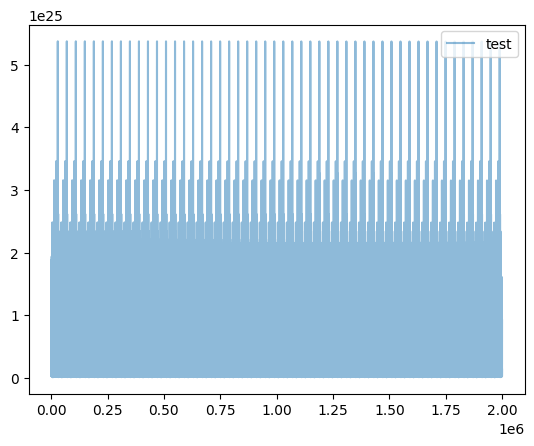

In [103]:
plt.figure()
plt.plot(all_losses_ft,label ='test',alpha = 0.5)
plt.legend()
plt.show()

MSE 8.027928020146417e+25
Median 2.7426988023672836e+24
Standard Devitaion inf


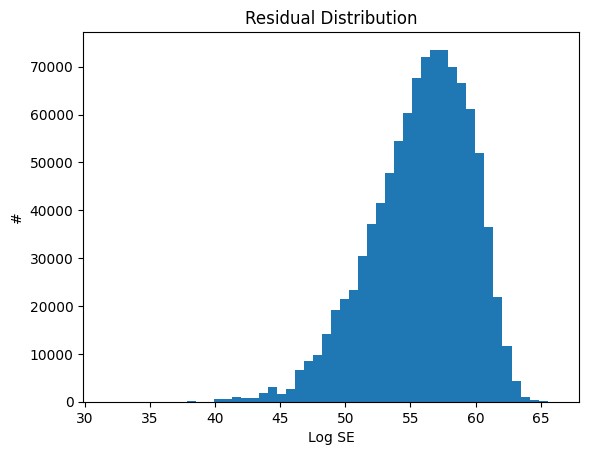

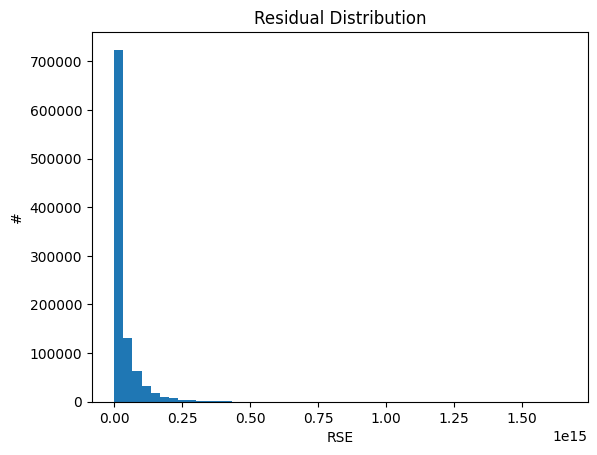

In [104]:
generate_stats(dae(test.cuda()),test.cuda())

In [66]:
cur = next(iter(train_dl_RBM))
print(dae(cur[0])[0])
print(cur[0][0])
print((dae(next(iter(train_dl_RBM))[0])[0]*maxes-next(iter(train_dl_RBM))[0][0]*maxes).int())

tensor([-0.5646, -0.3703, -0.5129, -0.5431, -0.4323, -0.5684, -0.5849, -0.4937,
        -0.5215, -0.5472, -0.4892, -0.4923, -0.4718, -0.5368, -0.4808, -0.5994,
        -0.5975, -0.5140, -0.4686, -0.4915, -0.5981, -0.5377, -0.5375, -0.4767,
        -0.5783, -0.4988, -0.5422, -0.5783, -0.6319, -0.5845, -0.4949, -0.5653,
        -0.5311, -0.4795, -0.5449, -0.5008, -0.4474, -0.5181, -0.5354, -0.5890,
        -0.5494, -0.6129, -0.4617, -0.5390, -0.4788, -0.4589, -0.4572, -0.6675],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0013, 0.0002, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], device='cuda:0')
tensor([ -7647,  -

In [6]:
def generate_stats(decoded, truth):
    eps = 10e-8
    #Printing basic info
    print(f'MSE {torch.mean(torch.sum((decoded-truth)**2,dim =1))}')
    print(f'Median {torch.median(torch.sum((decoded-truth)**2,dim =1))}')
    print(f'Standard Devitaion {torch.std(torch.sum((decoded-truth)**2,dim =1))}')
    
    
    
    #plotting residual distribution
    
    plt.figure()
    plt.hist(np.log10(torch.sum((decoded-truth).cpu()**2 +eps,dim =1).detach().numpy()), bins = 50)
    plt.xlabel('Log SE')
    plt.ylabel('#')
    plt.title('Residual Distribution')
    plt.show()
    
    plt.figure()
    plt.hist((torch.sum(torch.sqrt((decoded-truth).cpu()**2+eps),dim =1).detach().numpy()), bins = 50)
    plt.xlabel('RSE')
    plt.ylabel('#')
    plt.title('Residual Distribution')
    plt.show()
    
    pref = torch.hstack((test_loc[:,-2:],torch.sum((decoded)**2,dim=1,keepdim = True)**0.5,torch.sum((decoded-truth)**2,dim=1,keepdim = True)))
    plt.figure()
    plt.title('mse loss vs eta')
    plt.scatter(pref[:,0].detach().numpy(),pref[:,-1].detach().numpy(), s = 1, alpha = 0.75)
    plt.show()

    plt.figure()
    plt.title('mse loss vs phi')
    plt.scatter(pref[:,1].detach().numpy(),pref[:,-1].detach().numpy(), s = 1, alpha = 0.75)
    plt.show()

    plt.figure()
    plt.title('mse loss vs magnitude')
    plt.scatter(pref[:,2].detach().numpy(),pref[:,-1].detach().numpy(), s = 1, alpha = 0.75)
    plt.show()

    plt.figure()
    plt.title('magnitude vs eta')
    plt.scatter(pref[:,0].detach().numpy(),pref[:,2].detach().numpy(), s = 1, alpha = 0.75)
    plt.show()

In [7]:
"""Implementation of a Deep Autoencoder"""
import torch
import torch.nn as nn
import torch.nn.functional as F



class DAE(nn.Module):
    """A Deep Autoencoder that takes a list of RBMs as input"""

    def __init__(self, models):
        """Create a deep autoencoder based on a list of RBM models

        Parameters
        ----------
        models: list[RBM]
            a list of RBM models to use for autoencoding
        """
        super(DAE, self).__init__()

        # extract weights from each model
        encoders = []
        encoder_biases = []
        decoders = []
        decoder_biases = []
        for model in models:
            encoders.append(nn.Parameter(model.W.clone()))
            encoder_biases.append(nn.Parameter(model.h_bias.clone()))
            decoders.append(nn.Parameter(model.W.clone()))
            decoder_biases.append(nn.Parameter(model.v_bias.clone()))

        # build encoders and decoders
        self.encoders = nn.ParameterList(encoders)
        self.encoder_biases = nn.ParameterList(encoder_biases)
        self.decoders = nn.ParameterList(reversed(decoders))
        self.decoder_biases = nn.ParameterList(reversed(decoder_biases))

    def forward(self, v):
        """Forward step

        Parameters
        ----------
        v: Tensor
            input tensor

        Returns
        -------
        Tensor
            a reconstruction of v from the autoencoder

        """
        # encode
        p_h = self.encode(v)

        # decode
        p_v = self.decode(p_h)

        return p_v

    def encode(self, v):  # for visualization, encode without sigmoid
        """Encode input

        Parameters
        ----------
        v: Tensor
            visible input tensor

        Returns
        -------
        Tensor
            the activations of the last layer

        """
        p_v = v
        activation = v
        for i in range(len(self.encoders)):
            W = self.encoders[i]
            h_bias = self.encoder_biases[i]
            activation = torch.mm(p_v, W) + h_bias
            p_v = activation

        # for the last layer, we want to return the activation directly rather than the sigmoid
        return activation

    def decode(self, h):
        """Encode hidden layer

        Parameters
        ----------
        h: Tensor
            activations from last hidden layer

        Returns
        -------
        Tensor
            reconstruction of original input based on h

        """
        p_h = h
        for i in range(len(self.encoders)):
            W = self.decoders[i]
            v_bias = self.decoder_biases[i]
            activation = torch.mm(p_h, W.t()) + v_bias
            p_h = activation
        return p_h


class Naive_DAE(nn.Module):
    """A Naive implementation of the DAE to be trained without RBMs"""

    def __init__(self, layers):
        """Initialize the DAE

        Parameters
        ----------
        layers: list[int]
            the number of dimensions in each layer of the DAE

        """
        super(Naive_DAE, self).__init__()

        self.layers = layers
        encoders = []
        decoders = []
        prev_layer = layers[0]
        for layer in layers[1:]:
            encoders.append(
                nn.Linear(in_features=prev_layer, out_features=layer))
            encoders.append(
                nn.ReLU())
            
            decoders.append(
                nn.Linear(in_features=layer, out_features=prev_layer))
            decoders.append(
                nn.ReLU())
           
            prev_layer = layer
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))

    def forward(self, x):
        """Forward step
        
        Parameters
        ----------
        x: Tensor
            input tensor
        
        Returns
        -------
        Tensor
            a reconstructed version of x

        """
        x_encoded = self.encode(x)
        x_reconstructed = self.decode(x_encoded)
        return x_reconstructed

    def encode(self, x):
        """Encode the input x
        
        Parameters
        ----------
        x: Tensor
            input to encode
        
        Returns
        -------
        Tensor
            encoded input

        """
        for i, enc in enumerate(self.encoders):
            if i == len(self.encoders) - 1:
                x = enc(x)
            else:
                x = enc(x)
        return x
    
    def decode(self, x):
        """Decode the representation x
        
        Parameters
        ----------
        x: Tensor
            input to decode
        
        Returns
        -------
        Tensor
            decoded input

        """
        for dec in self.decoders:
            x = dec(x)
        return x

In [8]:
"""Utilities for training models in the demo"""
import torch



def train_rbm(train_dl, visible_dim, hidden_dim, k, num_epochs, lr, use_gaussian=False):
    """Create and train an RBM
    
    Uses a custom strategy to have 0.5 momentum before epoch 5 and 0.9 momentum after
    
    Parameters
    ----------
    train_dl: DataLoader
        training data loader
    visible_dim: int
        number of dimensions in visible (input) layer
    hidden_dim: int
        number of dimensions in hidden layer
    k: int
        number of iterations to run for Gibbs sampling (often 1 is used)
    num_epochs: int
        number of epochs to run for
    lr: float
        learning rate
    use_gaussian:
        whether to use a Gaussian distribution for the hidden state
    
    Returns
    -------
    RBM, Tensor, Tensor
        a trained RBM model, sample input tensor, reconstructed activation probabilities for sample input tensor

    """
    rbm = RBM(visible_dim=visible_dim, hidden_dim=hidden_dim, gaussian_hidden_distribution=use_gaussian)
    loss = torch.nn.MSELoss() # we will use MSE loss

    for epoch in range(num_epochs):
        train_loss = 0
        for i, data_list in enumerate(train_dl):
            sample_data = data_list[0].to(DEVICE)
            v0, pvk = sample_data, sample_data
            
            # Gibbs sampling
            for i in range(k):
                _, hk = rbm.sample_h(pvk)
                pvk = rbm.sample_v(hk)
            
            # compute ph0 and phk for updating weights
            ph0, _ = rbm.sample_h(v0)
            phk, _ = rbm.sample_h(pvk)
            
            # update weights
            rbm.update_weights(v0, pvk, ph0, phk, lr, 
                               momentum_coef=0.5 if epoch < 5 else 0.9, 
                               weight_decay=2e-4, 
                               batch_size=sample_data.shape[0])

            # track loss
            train_loss += loss(v0, pvk)
        
        # print training loss
        print(f"epoch {epoch}: {train_loss/len(train_dl)}")
    return rbm, v0, pvk

In [9]:
"""Implementation of a Restricted Boltzmann Machine"""
import torch




class RBM():
    """Implementation of a Restricted Boltzmann Machine
    
    Note that this implementation does not use Pytorch's nn.Module
    because we are updating the weights ourselves

    """
    def __init__(self, visible_dim, hidden_dim, gaussian_hidden_distribution=False):
        """Initialize a Restricted Boltzmann Machine

        Parameters
        ----------
        visible_dim: int
            number of dimensions in visible (input) layer
        hidden_dim: int
            number of dimensions in hidden layer
        gaussian_hidden_distribution: bool
            whether to use a Gaussian distribution for the values of the hidden dimension instead of a Bernoulli

        """
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.gaussian_hidden_distribution = gaussian_hidden_distribution

        # intialize parameters
        self.W = torch.randn(visible_dim, hidden_dim).to(DEVICE) * 0.1
        self.h_bias = torch.zeros(hidden_dim).to(DEVICE)  # v --> h
        self.v_bias = torch.zeros(visible_dim).to(DEVICE)  # h --> v

        # parameters for learning with momentum
        self.W_momentum = torch.zeros(visible_dim, hidden_dim).to(DEVICE)
        self.h_bias_momentum = torch.zeros(hidden_dim).to(DEVICE)  # v --> h
        self.v_bias_momentum = torch.zeros(visible_dim).to(DEVICE)  # h --> v

    def sample_h(self, v):
        """Get sample hidden values and activation probabilities

        Parameters
        ----------
        v: Tensor
            tensor of input from visible layer

        """
        activation = torch.mm(v, self.W) + self.h_bias
        if self.gaussian_hidden_distribution:
            return activation, torch.normal(activation, torch.tensor([1]).to(DEVICE))
        else:
            p = torch.sigmoid(activation)
            return p, torch.bernoulli(p)

    def sample_v(self, h):
        """Get visible activation probabilities

        Parameters
        ----------
        h: Tensor
            tensor of input from hidden

        """
        activation = torch.mm(h, self.W.t()) + self.v_bias
        p = torch.sigmoid(activation)
        return p

    def update_weights(self, v0, vk, ph0, phk, lr, momentum_coef, weight_decay, batch_size):
        """Learning step: update parameters 

        Uses contrastive divergence algorithm as described in

        Parameters
        ----------
        v0: Tensor
            initial visible state
        vk: Tensor
            final visible state
        ph0: Tensor
            hidden activation probabilities for v0
        phk: Tensor
            hidden activation probabilities for vk
        lr: float
            learning rate
        momentum_coef: float
            coefficient to use for momentum
        weight_decay: float
            coefficient to use for weight decay
        batch_size: int
            size of each batch

        """
        self.W_momentum *= momentum_coef
        self.W_momentum += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)

        self.h_bias_momentum *= momentum_coef
        self.h_bias_momentum += torch.sum((ph0 - phk), 0)

        self.v_bias_momentum *= momentum_coef
        self.v_bias_momentum += torch.sum((v0 - vk), 0)

        self.W += lr*self.W_momentum/batch_size
        self.h_bias += lr*self.h_bias_momentum/batch_size
        self.v_bias += lr*self.v_bias_momentum/batch_size

        self.W -= self.W * weight_decay # L2 weight decay

In [10]:
"""A set of generically helpful utility methods and constants"""
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
"""Which device to train the model on"""


def seed_everything(seed=42):
    """Seed everything to make the code more reproducable.

    This code is the same as that found from many public Kaggle kernels.

    Parameters
    ----------
    seed: int
        seed value to ues

    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def display_output(v0, vk, dim1=28, dim2=28, v0_fname=None, vk_fname=None):
    """Dsplaying the original and reconstructed images for comparison

    Parameters
    ----------
    v0: Tensor
        the original image
    vk: Tensor
        the reconstructed image
    dim1: int
        number of pixels on first dimension for plotting
    dim2: int
        number of pixels on second dimension for plotting
    v0_fname: str
        filename to save plot of original image in
    vk_fname: str
        filename to save plot of reconstructed image in

    """
    print("Original (top) and Reconstructed (bottom)")
    img = make_grid(v0.view(v0.shape[0], 1, dim1, dim2).data)
    npimg = np.transpose(img.detach().cpu().numpy(), (1, 2, 0))
    plt.imshow(npimg)
    if v0_fname is not None:
        plt.savefig(v0_fname)
    plt.show()
    img = make_grid(vk.view(vk.shape[0], 1, dim1, dim2).data)
    npimg = np.transpose(img.detach().cpu().numpy(), (1, 2, 0))
    plt.imshow(npimg)
    if vk_fname is not None:
        plt.savefig(vk_fname)    
    plt.show()


def display_2d_repr(data, labels, fname=None):
    """Display a 2d representation of the MNIST digits

    Parameters
    ----------
    data: Tensor
        2d representation of MNIST digits
    labels: list
        the label for each data point in data
    fname: str
        filename to save plot in

    """

    digit_to_color = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
                      "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
    xs = np.array([x[0] for x in data])
    ys = np.array([x[1] for x in data])

    fig, ax = plt.subplots()
    labels_to_show = labels[0:len(data)]
    for digit in range(10):
        ix = np.where(labels_to_show == digit)
        ax.scatter(xs[ix], ys[ix], c=digit_to_color[digit],
                   label=digit, marker=".")
    ax.legend()
    if fname is not None:
        plt.savefig(fname)
    plt.show()